In [223]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from skrmt.ensemble.spectral_law import MarchenkoPasturDistribution

from typing import Callable, Tuple

import torch
from diffusers import DDPMPipeline


In [224]:
def algorithm2_estimate_singular_values(
    score_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    x0: torch.Tensor,                 # shape (1, C, H, W)
    t0: torch.Tensor,                 # shape (1,) or scalar tensor (time / timestep)
    sigma_t0: float | torch.Tensor,   # scalar
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Algorithm 2.

    Require:
      score_fn: fonction qui renvoie s_theta(x, t) (même shape que x)
      x0: échantillon de data-set (1,C,H,W)
      t0: temps (tensor scalaire ou (1,))
      sigma_t0: niveau de bruit (scalaire)

    Returns:
      s: singular values (d,)
      v: left singular vectors (d,d)  (torch.linalg.svd convention: U)
      w: right singular vectors (d,d) (Vh.T)
      S: matrice (d,d)
    """

    # 1) Sample x0 ~ p0(x) : fourni en entrée
    # 2) d <- dim(x0)
    d = x0.numel()
    shape = x0.shape

    # 3) S <- empty matrix
    S = torch.empty((d, 0), device=x0.device, dtype=x0.dtype)

    # 4-8) Sample right/left perturbations
    Xp = []
    Xm = []
    for i in range(d):
        # 5) x+ ~ N(x0, sigma^2 I)
        x_plus = x0 + sigma_t0 * torch.randn_like(x0)
        # 6) x- ~ N(x0, sigma^2 I)
        x_minus = x0 + sigma_t0 * torch.randn_like(x0)
        # 7) x- <- 2 x0 - x-
        x_minus = 2 * x0 - x_minus
        Xp.append(x_plus)
        Xm.append(x_minus)

    Xp = torch.cat(Xp, dim=0)  # (d, C, H, W)
    Xm = torch.cat(Xm, dim=0)  # (d, C, H, W)

    # 9) orthogonalized perturbations
    # On orthogonalise les deltas autour de x0, puis on reconstruit x~ = x0 + delta~
    x0_flat = x0.reshape(1, d)
    dp = (Xp.reshape(d, d) - x0_flat)  # (d,d) lignes = deltas+
    dm = (Xm.reshape(d, d) - x0_flat)  # (d,d) lignes = deltas-

    # Orthogonalisation séparée pour + et - (le papier dit (x+, x-) -> orthogonalized)
    # Ici on applique QR aux transposées pour rendre les LIGNES orthonormales.
    Qp, _ = torch.linalg.qr(dp.T)  # (d,d)
    Qm, _ = torch.linalg.qr(dm.T)  # (d,d)

    dp_ortho = Qp.T
    dm_ortho = Qm.T

    Xp_tilde = (x0_flat + dp_ortho).reshape(d, *shape[1:])  # (d,C,H,W)
    Xm_tilde = (x0_flat + dm_ortho).reshape(d, *shape[1:])  # (d,C,H,W)
    # Xp_tilde = ((torch.linalg.qr(Xp.reshape(d, d))[0])).reshape(d, *shape[1:])  # (d,C,H,W)
    # Xm_tilde = ((torch.linalg.qr(Xm.reshape(d, d))[0])).reshape(d, *shape[1:])  # (d,C,H,W)

    # 10-12) remplir S colonne par colonne
    # (On suit exactement: append (s(x+)-s(x-))/2 as new column)
    for i in range(d):
        s_plus = score_fn(Xp_tilde[i:i+1], t0)   # (1,C,H,W)
        s_minus = score_fn(Xm_tilde[i:i+1], t0)  # (1,C,H,W)
        col = ((s_plus - s_minus) / 2.0).reshape(d, 1)      # (d,1)
        S = torch.cat([S, col], dim=1)  # append column

    # 13) SVD(S)
    # torch.linalg.svd retourne U, S, Vh avec S non vectorisée? -> S est vecteur des SVs
    U, sing_vals, Vh = torch.linalg.svd(S, full_matrices=True)

    # papier: (si), (vi), (wi) <- SVD(S)
    # on renvoie sing_vals, U, V (où V = Vh^T), et S
    V = Vh.transpose(-2, -1)

    return sing_vals, U, V, S


In [225]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist")
pipe = pipe.to(device)

unet = pipe.unet
scheduler = pipe.scheduler

unet.eval()

Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 87.67it/s]


UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [226]:
def score_fn(x, t0):
    # x: (B,1,28,28), t0: tensor (1,) ou (B,)
    if t0.ndim == 1 and t0.shape[0] == 1:
        t = t0.expand(x.shape[0]).to(device)
    else:
        t = t0.to(device)

    with torch.no_grad():
        eps_pred = unet(x, t).sample  # (B,1,28,28)

    # sigma_t = sqrt(1 - alpha_bar_t)
    alpha_bar = scheduler.alphas_cumprod[t].to(x.dtype).view(-1, 1, 1, 1)
    sigma_t = torch.sqrt(1.0 - alpha_bar)

    # score ≈ - eps / sigma
    return -eps_pred / sigma_t
    #return -eps_pred / np.sqrt(t + 0.01)

In [227]:
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

# MNIST: on met dans [-1, 1] (standard pour diffusion)
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2 * x - 1),
])

mnist = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)
x0, y = mnist[6]                      # x0: (1,28,28)
x0 = x0.unsqueeze(0).to(device)       # (1,1,28,28)



# Modèle diffusion MNIST (pré-entraîné HF)
pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)
unet = pipe.unet.eval()
scheduler = pipe.scheduler

Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 88.56it/s]


In [228]:
score_fn(x0, torch.tensor([0], device=device))[0, 0].shape

torch.Size([28, 28])

In [229]:
# test the algorithm
alpha_bar = scheduler.alphas_cumprod[0].to(x0.dtype).view(-1, 1, 1, 1)
sigma_t = torch.sqrt(1.0 - alpha_bar)

res = algorithm2_estimate_singular_values(
    score_fn,
    x0,
    torch.tensor([0], device=device),
    sigma_t0=sigma_t,
)

In [230]:
sing_val = res[0]
sing_val

tensor([4.5118e+03, 4.4987e+03, 4.4867e+03, 4.4807e+03, 4.4743e+03, 4.4696e+03,
        4.4527e+03, 4.4526e+03, 4.4480e+03, 4.4376e+03, 4.4329e+03, 4.4270e+03,
        4.4127e+03, 4.4105e+03, 4.4097e+03, 4.4007e+03, 4.3941e+03, 4.3904e+03,
        4.3846e+03, 4.3800e+03, 4.3758e+03, 4.3695e+03, 4.3602e+03, 4.3565e+03,
        4.3514e+03, 4.3485e+03, 4.3436e+03, 4.3381e+03, 4.3317e+03, 4.3266e+03,
        4.3249e+03, 4.3222e+03, 4.3140e+03, 4.3030e+03, 4.2985e+03, 4.2963e+03,
        4.2948e+03, 4.2880e+03, 4.2818e+03, 4.2791e+03, 4.2746e+03, 4.2683e+03,
        4.2635e+03, 4.2595e+03, 4.2551e+03, 4.2522e+03, 4.2446e+03, 4.2379e+03,
        4.2364e+03, 4.2296e+03, 4.2288e+03, 4.2284e+03, 4.2239e+03, 4.2188e+03,
        4.2141e+03, 4.2115e+03, 4.2079e+03, 4.2030e+03, 4.1957e+03, 4.1901e+03,
        4.1876e+03, 4.1851e+03, 4.1787e+03, 4.1767e+03, 4.1720e+03, 4.1647e+03,
        4.1580e+03, 4.1536e+03, 4.1479e+03, 4.1454e+03, 4.1410e+03, 4.1337e+03,
        4.1316e+03, 4.1298e+03, 4.1247e+

In [231]:
sing_val = res[0]
sing_val = sing_val.cpu().numpy()
sing_val = sing_val[1:]
sing_val /= sing_val.max()
sing_val

array([1.00000000e+00, 9.97342288e-01, 9.96014774e-01, 9.94577169e-01,
       9.93539751e-01, 9.89791811e-01, 9.89755869e-01, 9.88744795e-01,
       9.86430347e-01, 9.85384643e-01, 9.84077632e-01, 9.80885208e-01,
       9.80405033e-01, 9.80233192e-01, 9.78220522e-01, 9.76764917e-01,
       9.75934505e-01, 9.74642694e-01, 9.73630428e-01, 9.72692668e-01,
       9.71292853e-01, 9.69230056e-01, 9.68393743e-01, 9.67270494e-01,
       9.66624677e-01, 9.65523660e-01, 9.64314282e-01, 9.62889612e-01,
       9.61742461e-01, 9.61377800e-01, 9.60767567e-01, 9.58951712e-01,
       9.56506550e-01, 9.55507457e-01, 9.55023170e-01, 9.54676270e-01,
       9.53176260e-01, 9.51797009e-01, 9.51193690e-01, 9.50195193e-01,
       9.48789418e-01, 9.47719216e-01, 9.46831465e-01, 9.45857644e-01,
       9.45212185e-01, 9.43526983e-01, 9.42044556e-01, 9.41696286e-01,
       9.40193892e-01, 9.40011740e-01, 9.39914167e-01, 9.38922346e-01,
       9.37788248e-01, 9.36742365e-01, 9.36172843e-01, 9.35357809e-01,
      

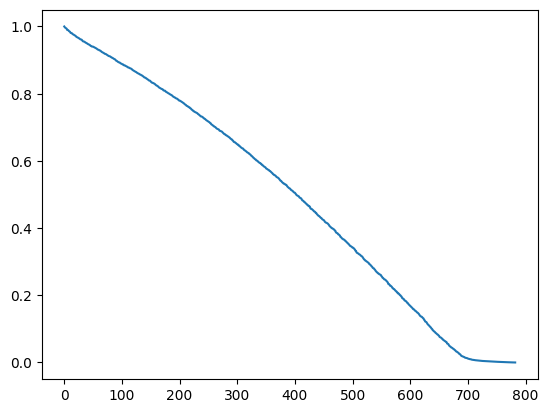

In [232]:
plt.plot(list(range(len(sing_val))), sing_val)